# Predicting interest rates from Federal Reserve documents
## Preprocessing I (Vol. 2)
FE 690: Machine Learning in Finance \\
Author: Theo Dimitrasopoulos \\
Advisor: Zachary Feinstein \\

In [1]:
import sys
IN_COLAB = 'google.colab' in sys.modules
IN_COLAB

True

In [2]:
if IN_COLAB:
    from google.colab import drive
    drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [3]:
# Uninstall existing versions:
#!pip uninstall numpy -y
#!pip uninstall pandas -y
#!pip uninstall tqdm -y
#!pip uninstall torch -y
#!pip uninstall scikit-plot -y
#!pip uninstall transformers -y

# Install packages:
#!pip install numpy==1.16.4

# Original Pandas
#!pip install pandas==0.25.0
# Working Pandas
#!pip install pandas

#!pip install torch==1.4.0
#!pip install tqdm==4.43.0
#!pip install scikit-plot
#!pip install transformers

In [4]:
import numpy as np
import pandas as pd
import datetime as dt
import os
from lxml import etree
from dateutil.relativedelta import *
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import pickle
from tqdm.notebook import tqdm
import re


In [5]:
# Set display preference (Optional)
plt.rcParams["figure.figsize"] = (18,9)
plt.style.use('fivethirtyeight')
sns.set(style='white', context='notebook', palette='deep')

pd.options.display.max_rows = 20
pd.options.display.max_seq_items = 50
pd.set_option('display.max_colwidth', 200)

In [6]:
if IN_COLAB:
  employment_data_dir = '/content/drive/My Drive/Colab Notebooks/proj2/src/data/MarketData/Employment/'
  cpi_data_dir = '/content/drive/My Drive/Colab Notebooks/proj2/src/data/MarketData/CPI/'
  fed_rates_dir = '/content/drive/My Drive/Colab Notebooks/proj2/src/data/MarketData/FEDRates/'
  fx_rates_dir = '/content/drive/My Drive/Colab Notebooks/proj2/src/data/MarketData/FXRates/'
  gdp_data_dir = '/content/drive/My Drive/Colab Notebooks/proj2/src/data/MarketData/GDP/'
  ism_data_dir = '/content/drive/My Drive/Colab Notebooks/proj2/src/data/MarketData/ISM/'
  sales_data_dir = '/content/drive/My Drive/Colab Notebooks/proj2/src/data/MarketData/Sales/'
  treasury_data_dir = '/content/drive/My Drive/Colab Notebooks/proj2/src/data/MarketData/Treasury/'
  fomc_dir = '/content/drive/My Drive/Colab Notebooks/proj2/src/data/FOMC/'
  preprocessed_dir = '/content/drive/My Drive/Colab Notebooks/proj2/src/data/preprocessed/'
  train_dir = '/content/drive/My Drive/Colab Notebooks/proj2/src/data/train_data/'
  output_dir = '/content/drive/My Drive/Colab Notebooks/proj2/src/data/result/'
  keyword_lm_dir = '/content/drive/My Drive/Colab Notebooks/proj2/src/data/LoughranMcDonald/'
  glove_dir = '/content/drive/My Drive/Colab Notebooks/proj2/src/data/GloVe/'
  model_dir = '/content/drive/My Drive/Colab Notebooks/proj2/src/data/models/'
else:
  employment_data_dir = 'C:/Users/theon/GDrive/Colab Notebooks/proj2/src/data/MarketData/Employment/'
  cpi_data_dir = 'C:/Users/theon/GDrive/Colab Notebooks/proj2/src/data/MarketData/CPI/'
  fed_rates_dir = 'C:/Users/theon/GDrive/Colab Notebooks/proj2/src/data/MarketData/FEDRates/'
  fx_rates_dir = 'C:/Users/theon/GDrive/Colab Notebooks/proj2/src/data/MarketData/FXRates/'
  gdp_data_dir = 'C:/Users/theon/GDrive/Colab Notebooks/proj2/src/data/MarketData/GDP/'
  ism_data_dir = 'C:/Users/theon/GDrive/Colab Notebooks/proj2/src/data/MarketData/ISM/'
  sales_data_dir = 'C:/Users/theon/GDrive/Colab Notebooks/proj2/src/data/MarketData/Sales/'
  treasury_data_dir = 'C:/Users/theon/GDrive/Colab Notebooks/proj2/src/data/MarketData/Treasury/'
  fomc_dir = 'C:/Users/theon/GDrive/Colab Notebooks/proj2/src/data/FOMC/'
  preprocessed_dir = 'C:/Users/theon/GDrive/Colab Notebooks/proj2/src/data/preprocessed/'
  train_dir = 'C:/Users/theon/GDrive/Colab Notebooks/proj2/src/data/train_data/'
  output_dir = 'C:/Users/theon/GDrive/Colab Notebooks/proj2/src/data/result/'
  keyword_lm_dir = 'C:/Users/theon/GDrive/Colab Notebooks/proj2/src/data/LoughranMcDonald/'
  glove_dir = 'C:/Users/theon/GDrive/Colab Notebooks/proj2/src/data/GloVe/'
  model_dir = 'C:/Users/theon/GDrive/Colab Notebooks/proj2/src/data/models/'

## FOMC Meeting Minutes

### Chairpersons

In [7]:
# FOMC Chairperson's list
chairpersons = pd.DataFrame(
    data=[["Volcker", "Paul", dt.datetime(1979,8,6), dt.datetime(1987,8,10)],
          ["Greenspan", "Alan", dt.datetime(1987,8,11), dt.datetime(2006,1,31)], 
          ["Bernanke", "Ben", dt.datetime(2006,2,1), dt.datetime(2014,1,31)], 
          ["Yellen", "Janet", dt.datetime(2014,2,3), dt.datetime(2018,2,3)],
          ["Powell", "Jerome", dt.datetime(2018,2,5), dt.datetime(2022,2,5)]],
    columns=["Surname", "FirstName", "FromDate", "ToDate"])
chairpersons

,Surname,FirstName,FromDate,ToDate
0,Volcker,Paul,1979-08-06,1987-08-10
1,Greenspan,Alan,1987-08-11,2006-01-31
2,Bernanke,Ben,2006-02-01,2014-01-31
3,Yellen,Janet,2014-02-03,2018-02-03
4,Powell,Jerome,2018-02-05,2022-02-05


In [8]:
def get_chairperson(x):
    if type(x) is str:
        try:
            x = dt.datetime.strftime(x, '%Y-%m-%d')
        except:
            return None
    
    chairperson = chairpersons.loc[chairpersons['FromDate'] <= x].loc[x <= chairpersons['ToDate']]
    return list(chairperson.FirstName)[0] + " " + list(chairperson.Surname)[0]

### Calendar

In [9]:
# Pickle
file = open(fomc_dir + 'fomc_calendar.pickle', 'rb')
fomc_calendar = pickle.load(file)
file.close()
# Comma-Delimited
# fomc_calendar = pd.read_csv(fomc_dir + 'fomc_calendar.csv')
fomc_calendar

,date,unscheduled,forecast,confcall
0,1980-01-09,False,False,False
1,1980-02-05,False,False,False
2,1980-02-22,False,False,True
3,1980-03-07,False,False,True
4,1980-03-18,False,False,False
...,...,...,...,...
441,2021-06-16,False,True,False
442,2021-07-28,False,False,False
443,2021-09-22,False,True,False
444,2021-11-03,False,False,False


In [10]:
fomc_calendar = fomc_calendar.loc[fomc_calendar['date'] >= dt.datetime(1982, 9, 27)]
fomc_calendar.set_index('date', inplace=True)
fomc_calendar.head()

,unscheduled,forecast,confcall
date,,,
1982-10-05,False,False,False
1982-11-16,False,False,False
1982-12-21,False,False,False
1983-01-14,False,False,True
1983-01-21,False,False,True


### Add Chairpersons to Calendar

In [11]:
fomc_calendar['ChairPerson'] = fomc_calendar.index.map(get_chairperson)
fomc_calendar

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,unscheduled,forecast,confcall,ChairPerson
date,,,,
1982-10-05,False,False,False,Paul Volcker
1982-11-16,False,False,False,Paul Volcker
1982-12-21,False,False,False,Paul Volcker
1983-01-14,False,False,True,Paul Volcker
1983-01-21,False,False,True,Paul Volcker
...,...,...,...,...
2021-06-16,False,True,False,Jerome Powell
2021-07-28,False,False,False,Jerome Powell
2021-09-22,False,True,False,Jerome Powell


## Market Data

### Target FED Rate

Source: Federal Reserve Bank of New York (https://apps.newyorkfed.org/markets/autorates/fed%20funds)

In [12]:
filename = fed_rates_dir + 'ffs-01172000-02092020.csv'

fedrates = pd.read_csv(filename, header=0, names=('Date', 'Vol', 'EFFR', '1st','25th' ,'75th' ,'99th' ,'Target' ,'Low' ,'High','Std.' ))
fedrates.index = pd.to_datetime(fedrates.Date, format="%d/%m/%Y")
fedrates.dropna(inplace=True, axis=0, subset=['Date', 'Target'])
fedrates.drop(columns=['Date', 'Vol', 'EFFR', '1st','25th' ,'75th' ,'99th','Low' ,'High','Std.'], inplace=True)

fedrates['Low'] = None
fedrates['High'] = None

for i in range(fedrates.shape[0]):
    target = fedrates['Target'][i]
    if '-' in target:
        fedrates['Low'][i] = re.findall(r'([0-9.]+)-', target)[0]
        fedrates['High'][i] = re.findall(r'-([0-9.]+)', target)[0]
    else:
        (fedrates['Low'][i], fedrates['High'][i]) = (target, target)

fedrates

,Target,Low,High
Date,,,
2020-02-06,1.50-1.75,1.50,1.75
2020-02-05,1.50-1.75,1.50,1.75
2020-02-04,1.50-1.75,1.50,1.75
2020-02-03,1.50-1.75,1.50,1.75
2020-01-31,1.50-1.75,1.50,1.75
...,...,...,...
2000-07-10,6.5,6.5,6.5
2000-07-07,6.5,6.5,6.5
2000-07-06,6.5,6.5,6.5


In [13]:
fedrates.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4925 entries, 2020-02-06 to 2000-07-03
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Target  4925 non-null   object
 1   Low     4925 non-null   object
 2   High    4925 non-null   object
dtypes: object(3)
memory usage: 153.9+ KB


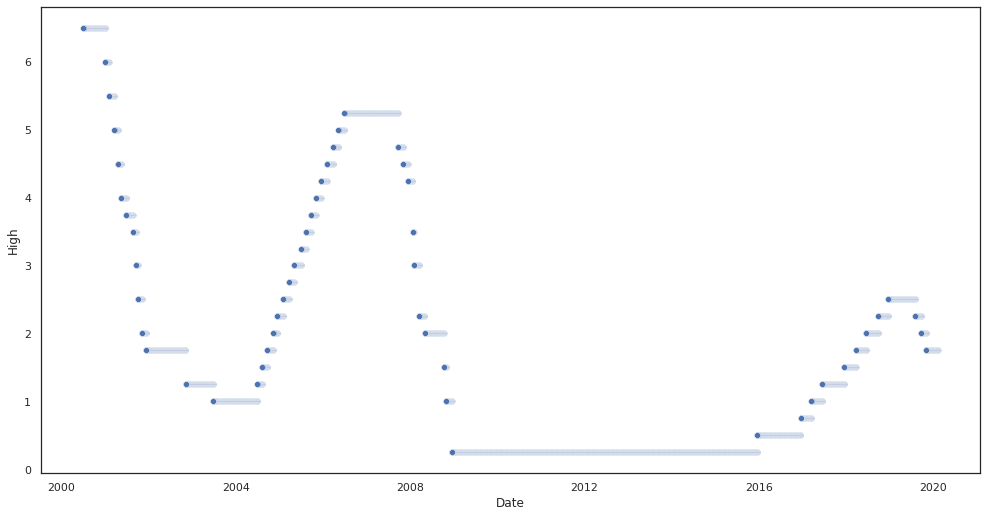

In [14]:
plt.figure(figsize=(15,8))
ax = sns.scatterplot(data=(fedrates["High"].apply(lambda x: float(x))))

Looks good, but FRB of New York has historical data only from 2000.

So, download from FRB of St. Louis 
(https://fred.stlouisfed.org/searchresults?nasw=0&st=FED%20Rate&t=rate%3Bfederal%3Binterest%20rate&ob=sr&od=desc&types=gen).

Download the following three files in csv:

 * Federal Funds Target Range - Upper Limit
 * Federal Funds Target Range - Lower Limit
 * Federal Funds Target Rate (DISCONTINUED)

In [15]:
filename_till08 = fed_rates_dir + 'DFEDTAR.csv'
filename_from08u = fed_rates_dir + 'DFEDTARU.csv'
filename_from08l = fed_rates_dir + 'DFEDTARL.csv'

fedtar = pd.read_csv(filename_till08, names=['Date', 'Rate'], header=0)
fedtaru = pd.read_csv(filename_from08u, names=['Date', 'Rate'], header=0)
fedtarl = pd.read_csv(filename_from08l, names=['Date', 'Rate'], header=0)
fedrate_df = pd.concat([fedtar, fedtarl], axis=0)
fedrate_df.index = pd.to_datetime(fedrate_df.Date, format="%Y-%m-%d")
fedrate_df.drop(columns=['Date'], inplace=True)
fedrate_df['Rate'] = fedrate_df['Rate'].map(lambda x: np.float(x))
fedrate_df['diff'] = fedrate_df['Rate'].diff()

fedrate_df

,Rate,diff
Date,,
1982-09-27,10.25,NaN
1982-09-28,10.25,0.00
1982-09-29,10.25,0.00
1982-09-30,10.25,0.00
1982-10-01,10.00,-0.25
...,...,...
2020-05-30,0.00,0.00
2020-05-31,0.00,0.00
2020-06-01,0.00,0.00


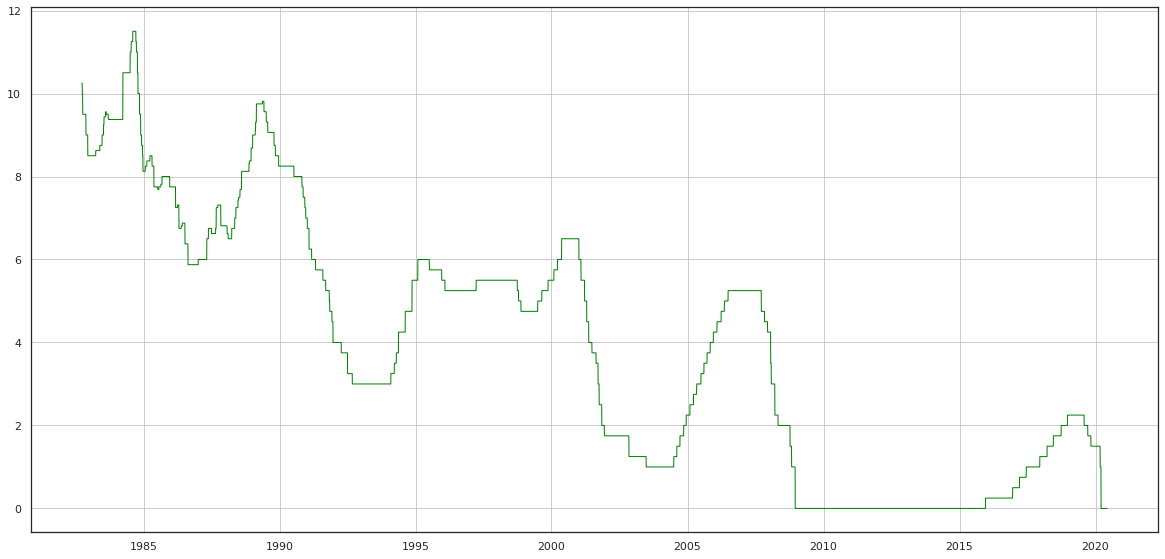

In [16]:
fig, ax = plt.subplots()
ax.plot(fedrate_df.index, fedrate_df['Rate'].values, 
         c = 'green',
         linewidth= 1.0)
ax.grid(True)
plt.show()

### Effective FED Rate

In [17]:
filename = fed_rates_dir + 'DFF.csv'
dff = pd.read_csv(filename, header=0)
dff = dff.set_index(pd.to_datetime(dff['DATE'], format="%Y-%m-%d")).drop(columns=['DATE'])
dff['diff'] = dff['DFF'].diff()
dff

,DFF,diff
DATE,,
1954-07-01,1.13,NaN
1954-07-02,1.25,0.12
1954-07-03,1.25,0.00
1954-07-04,1.25,0.00
1954-07-05,0.88,-0.37
...,...,...
2020-05-30,0.05,0.00
2020-05-31,0.05,0.00
2020-06-01,0.05,0.00


(803, 2)


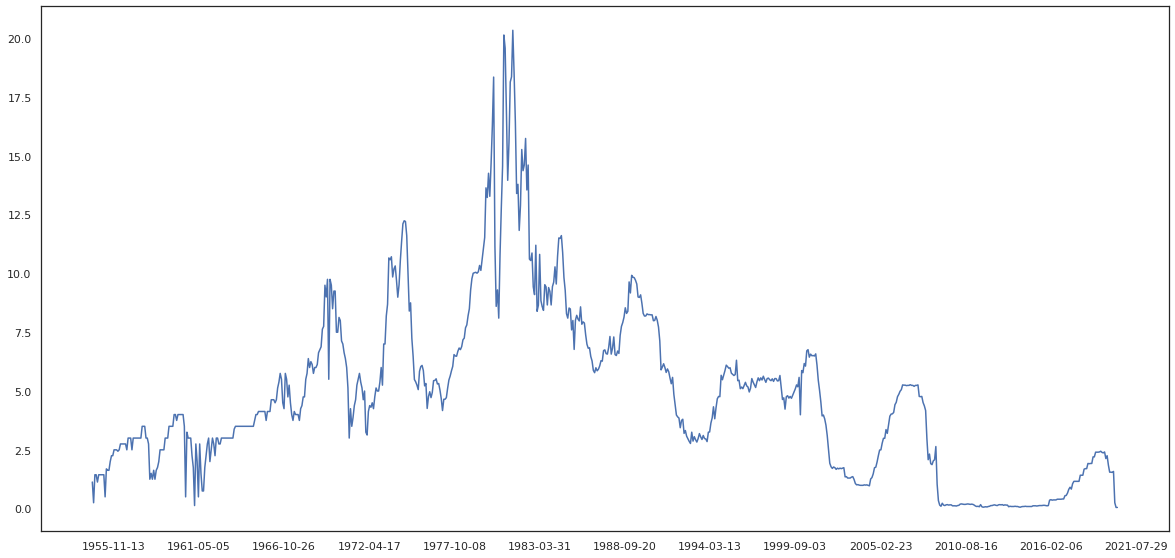

In [18]:
# Use every 30th row as it has too many data points
dff_30 = dff.iloc[::30, :]
print(dff_30.shape)

fig, ax = plt.subplots()
ax.plot(dff_30.index.values, dff_30['DFF'].values)
ax.xaxis.set_major_locator(ticker.MultipleLocator(2000))
plt.show()

## Economic Indices

### GDP

In [19]:
# Billions of Chained 2012 Dollars, Seasonally Adjusted Annual Rate
filename = gdp_data_dir + 'GDPC1.csv'

gdpc1 = pd.read_csv(filename, header=0)
gdpc1 = gdpc1.set_index(pd.to_datetime(gdpc1['DATE'], format="%Y-%m-%d")).drop(columns=['DATE'])
gdpc1['diff_prev'] = gdpc1['GDPC1'].diff() / gdpc1['GDPC1'].shift(1) * 100
gdpc1['diff_year'] = gdpc1['GDPC1'].diff(periods=4) / gdpc1['GDPC1'].shift(4) * 100
gdpc1

,GDPC1,diff_prev,diff_year
DATE,,,
1947-01-01,2033.061,NaN,NaN
1947-04-01,2027.639,-0.266691,NaN
1947-07-01,2023.452,-0.206496,NaN
1947-10-01,2055.103,1.564208,NaN
1948-01-01,2086.017,1.504256,2.604742
...,...,...,...
2019-01-01,18927.281,0.765207,2.652241
2019-04-01,19021.860,0.499697,2.278320
2019-07-01,19121.112,0.521779,2.073335


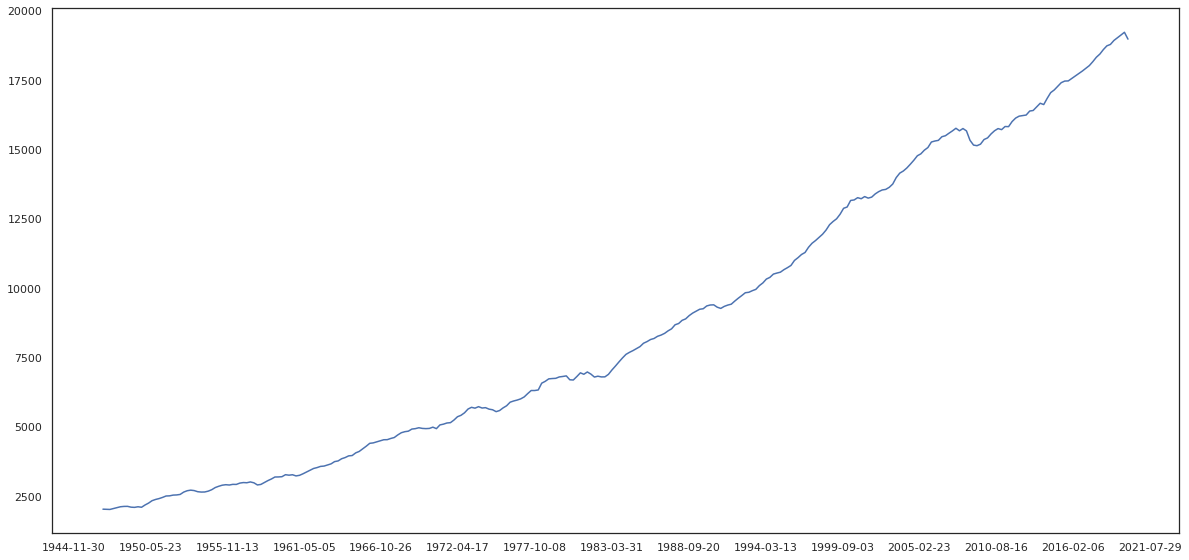

In [20]:
fig, ax = plt.subplots()
ax.plot(gdpc1.index.values, gdpc1['GDPC1'].values)
ax.xaxis.set_major_locator(ticker.MultipleLocator(2000))
plt.show()

### Potential GDP

In [21]:
# Billions of Chained 2012 Dollars, Not Seasonally Adjusted
filename = gdp_data_dir + 'GDPPOT.csv'

gdppot = pd.read_csv(filename, header=0)
gdppot = gdppot.set_index(pd.to_datetime(gdppot['DATE'], format="%Y-%m-%d")).drop(columns=['DATE'])
gdppot['diff_prev'] = gdppot['GDPPOT'].diff() / gdppot['GDPPOT'].shift(1) * 100
gdppot['diff_year'] = gdppot['GDPPOT'].diff(periods=4) / gdppot['GDPPOT'].shift(4) * 100
gdppot

,GDPPOT,diff_prev,diff_year
DATE,,,
1949-01-01,2105.424751,NaN,NaN
1949-04-01,2133.335241,1.325647,NaN
1949-07-01,2162.374385,1.361209,NaN
1949-10-01,2190.094474,1.281928,NaN
1950-01-01,2219.369859,1.336718,5.411977
...,...,...,...
2029-10-01,22899.670000,0.431070,1.749088
2030-01-01,22997.870000,0.428827,1.742254
2030-04-01,23096.170000,0.427431,1.732649


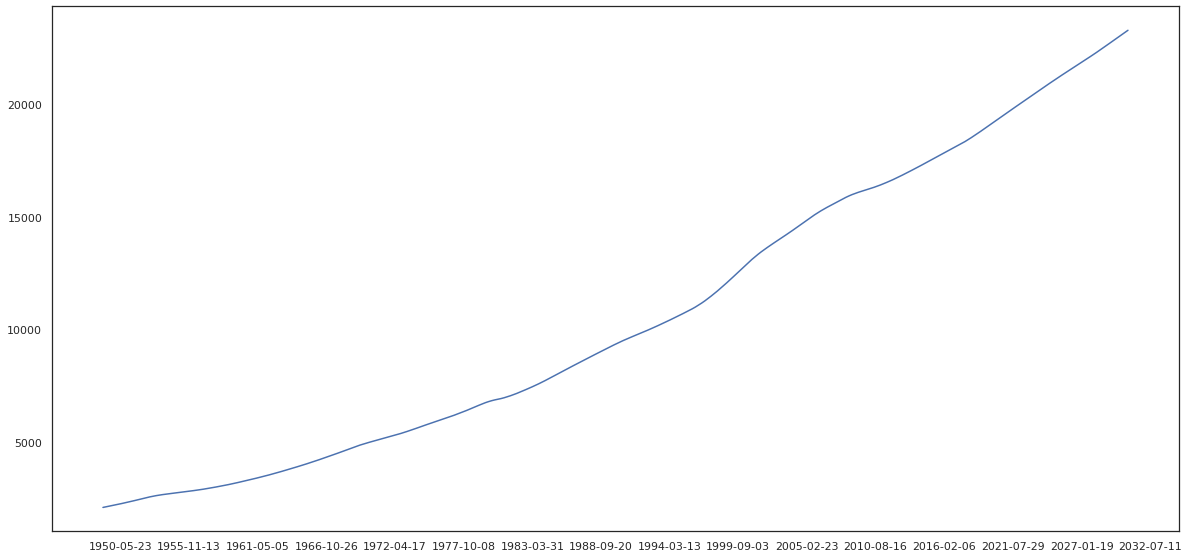

In [22]:
fig, ax = plt.subplots()
ax.plot(gdppot.index.values, gdppot['GDPPOT'].values)
ax.xaxis.set_major_locator(ticker.MultipleLocator(2000))
plt.show()

### Personal Consumption: PCE

Use Core PCE excluding Food and Energy (per FRB recommendations) <BR />

In [23]:
filename = cpi_data_dir + 'PCEPILFE.csv'
pcepilfe = pd.read_csv(filename, header=0)
pcepilfe = pcepilfe.set_index(pd.to_datetime(pcepilfe['DATE'], format="%Y-%m-%d")).drop(columns=['DATE'])
pcepilfe['diff_prev'] = pcepilfe['PCEPILFE'].diff() / pcepilfe['PCEPILFE'].shift(1) * 100
pcepilfe['diff_year'] = pcepilfe['PCEPILFE'].diff(periods=12) / pcepilfe['PCEPILFE'].shift(12) * 100
pcepilfe

,PCEPILFE,diff_prev,diff_year
DATE,,,
1959-01-01,16.727,NaN,NaN
1959-02-01,16.740,0.077719,NaN
1959-03-01,16.759,0.113501,NaN
1959-04-01,16.801,0.250612,NaN
1959-05-01,16.822,0.124993,NaN
...,...,...,...
2019-12-01,112.550,0.233329,1.568422
2020-01-01,112.725,0.155486,1.689640
2020-02-01,112.886,0.142825,1.796310


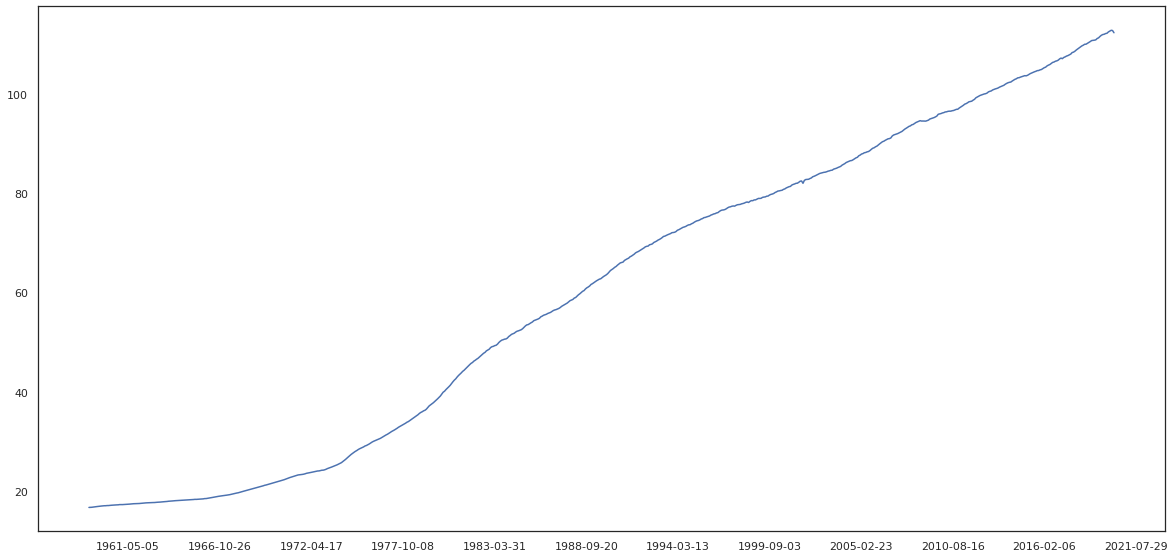

In [24]:
fig, ax = plt.subplots()
ax.plot(pcepilfe.index.values, pcepilfe['PCEPILFE'].values)
ax.xaxis.set_major_locator(ticker.MultipleLocator(2000))
plt.show()

### Personal Consumption: CPI

In [25]:
filename = cpi_data_dir + 'CPIAUCSL.csv'
cpiaucsl = pd.read_csv(filename, header=0)
cpiaucsl = cpiaucsl.set_index(pd.to_datetime(cpiaucsl['DATE'], format="%Y-%m-%d")).drop(columns=['DATE'])
cpiaucsl['diff_prev'] = cpiaucsl['CPIAUCSL'].diff() / cpiaucsl['CPIAUCSL'].shift(1) * 100
cpiaucsl['diff_year'] = cpiaucsl['CPIAUCSL'].diff(periods=12) / cpiaucsl['CPIAUCSL'].shift(12) * 100
cpiaucsl

,CPIAUCSL,diff_prev,diff_year
DATE,,,
1947-01-01,21.480,NaN,NaN
1947-02-01,21.620,0.651769,NaN
1947-03-01,22.000,1.757632,NaN
1947-04-01,22.000,0.000000,NaN
1947-05-01,21.950,-0.227273,NaN
...,...,...,...
2020-01-01,258.820,0.145486,2.482677
2020-02-01,259.050,0.088865,2.318104
2020-03-01,257.953,-0.423470,1.518330


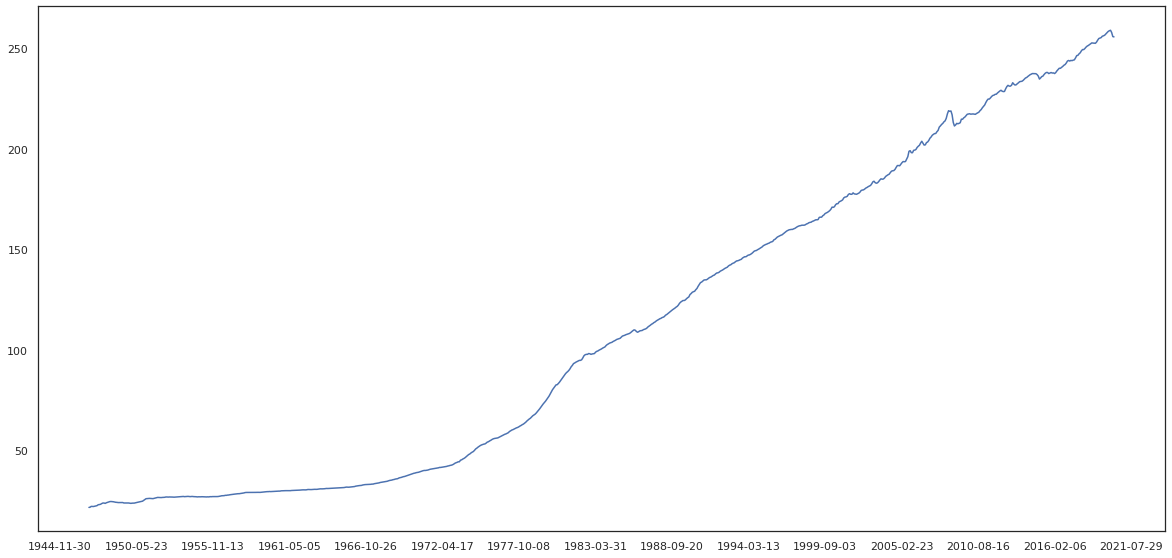

In [26]:
fig, ax = plt.subplots()
ax.plot(cpiaucsl.index.values, cpiaucsl['CPIAUCSL'].values)
ax.xaxis.set_major_locator(ticker.MultipleLocator(2000))
plt.show()

### Unemployment

FRB's decision is weighed heavily by unemployment data.

In [27]:
filename = employment_data_dir + 'UNRATE.csv'
unrate = pd.read_csv(filename, header=0)
unrate = unrate.set_index(pd.to_datetime(unrate['DATE'], format="%Y-%m-%d")).drop(columns=['DATE'])
unrate['UNRATE'] = unrate['UNRATE'] * -1
unrate['diff_prev'] = unrate['UNRATE'].diff()
unrate['diff_year'] = unrate['UNRATE'].diff(periods=12)
unrate

,UNRATE,diff_prev,diff_year
DATE,,,
1948-01-01,-3.4,NaN,NaN
1948-02-01,-3.8,-0.4,NaN
1948-03-01,-4.0,-0.2,NaN
1948-04-01,-3.9,0.1,NaN
1948-05-01,-3.5,0.4,NaN
...,...,...,...
2020-01-01,-3.6,-0.1,0.4
2020-02-01,-3.5,0.1,0.3
2020-03-01,-4.4,-0.9,-0.6


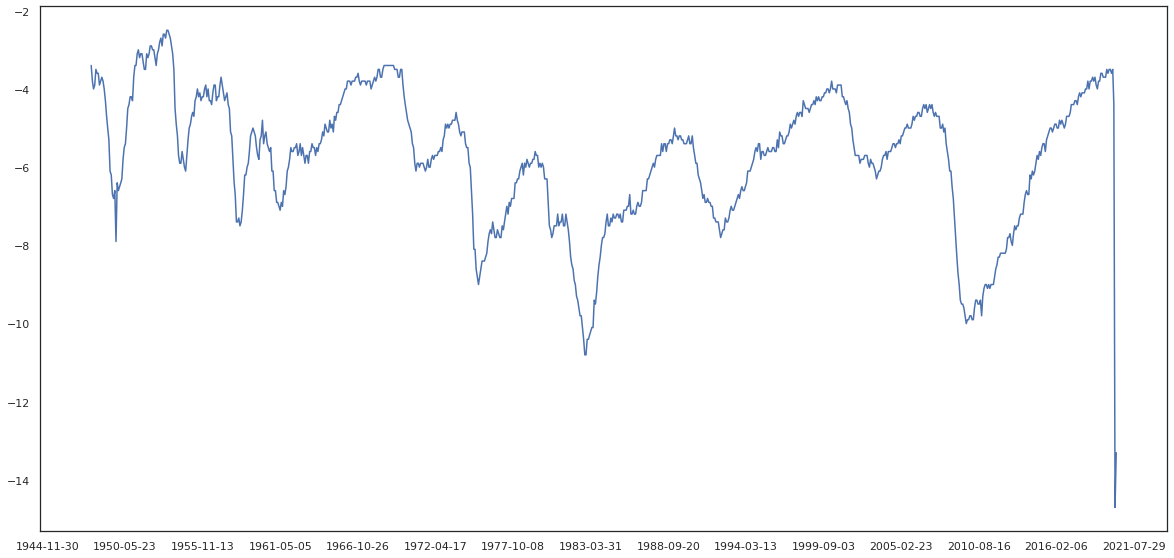

In [28]:
fig, ax = plt.subplots()
ax.plot(unrate.index.values, unrate['UNRATE'].values)
ax.xaxis.set_major_locator(ticker.MultipleLocator(2000))
plt.show()

### Employment

In [29]:
filename = employment_data_dir + 'PAYEMS.csv'
payems = pd.read_csv(filename, header=0)
payems = payems.set_index(pd.to_datetime(payems['DATE'], format="%Y-%m-%d")).drop(columns=['DATE'])
payems['diff_prev'] = payems['PAYEMS'].diff()
payems['diff_year'] = payems['PAYEMS'].diff(periods=12)
payems

,PAYEMS,diff_prev,diff_year
DATE,,,
1939-01-01,29923,NaN,NaN
1939-02-01,30100,177.0,NaN
1939-03-01,30280,180.0,NaN
1939-04-01,30094,-186.0,NaN
1939-05-01,30299,205.0,NaN
...,...,...,...
2020-01-01,152212,214.0,2078.0
2020-02-01,152463,251.0,2328.0
2020-03-01,151090,-1373.0,808.0


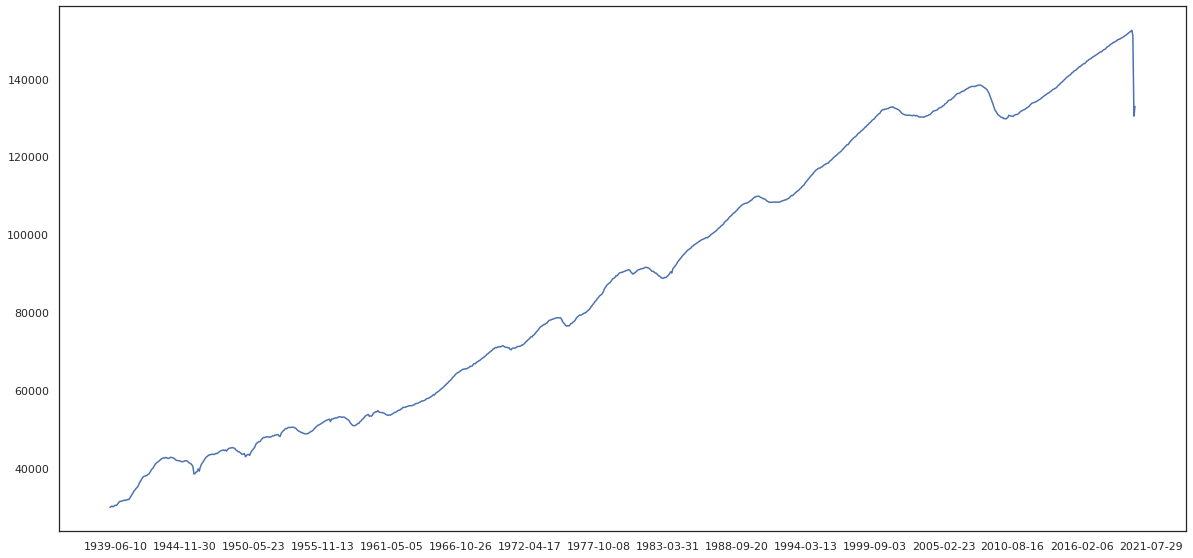

In [30]:
fig, ax = plt.subplots()
ax.plot(payems.index.values, payems['PAYEMS'].values)
ax.xaxis.set_major_locator(ticker.MultipleLocator(2000))
plt.show()

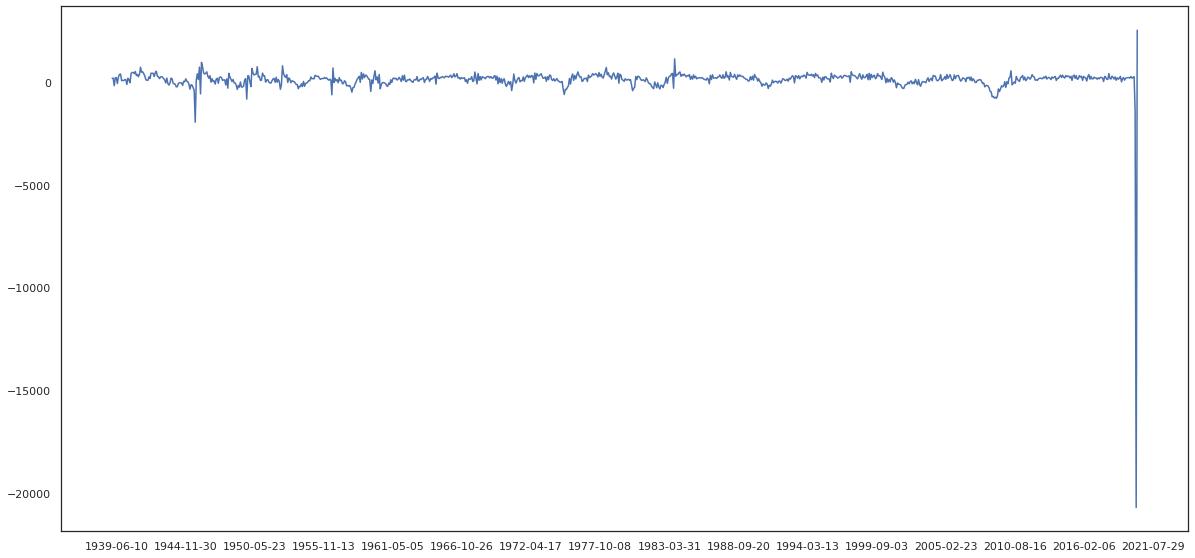

In [31]:
fig, ax = plt.subplots()
ax.plot(payems.index.values, payems['diff_prev'].values)
ax.xaxis.set_major_locator(ticker.MultipleLocator(2000))
plt.show()

### ISM Purchasing Managers Index / Non-manufacturing Index

In [32]:
filename = ism_data_dir + 'ISM-MAN_PMI.csv'
ism_pmi = pd.read_csv(filename, header=0)
ism_pmi = ism_pmi.sort_values(by=['Date'], ascending=True)
ism_pmi = ism_pmi.set_index(pd.to_datetime(ism_pmi['Date'], format="%Y-%m-%d")).drop(columns=['Date'])
ism_pmi['diff_prev'] = ism_pmi['PMI'].diff()
ism_pmi['diff_year'] = ism_pmi['PMI'].diff(periods=12)
ism_pmi

,PMI,diff_prev,diff_year
Date,,,
1948-01-01,51.7,NaN,NaN
1948-02-01,50.2,-1.5,NaN
1948-03-01,43.3,-6.9,NaN
1948-04-01,45.4,2.1,NaN
1948-05-01,49.5,4.1,NaN
...,...,...,...
2020-01-01,50.9,3.1,-5.7
2020-02-01,50.1,-0.8,-4.0
2020-03-01,49.1,-1.0,-5.5


In [33]:
# Load ISM NMI
filename = ism_data_dir + 'ISM-NONMAN_NMI.csv'

ism_nmi = pd.read_csv(filename, header=0)
ism_nmi = ism_nmi.sort_values(by=['Date'], ascending=True)
ism_nmi.columns = ['Date', 'NMI']
ism_nmi = ism_nmi.set_index(pd.to_datetime(ism_nmi['Date'], format="%Y-%m-%d")).drop(columns=['Date'])
# Add difference from previous value
ism_nmi['diff_prev'] = ism_nmi['NMI'].diff()
ism_nmi['diff_year'] = ism_nmi['NMI'].diff(periods=12)
ism_nmi

,NMI,diff_prev,diff_year
Date,,,
2008-01-01,45.0,NaN,NaN
2008-02-01,49.9,4.9,NaN
2008-03-01,49.4,-0.5,NaN
2008-04-01,51.8,2.4,NaN
2008-05-01,51.4,-0.4,NaN
...,...,...,...
2020-01-01,55.5,0.6,-1.2
2020-02-01,57.3,1.8,-2.4
2020-03-01,52.5,-4.8,-3.6


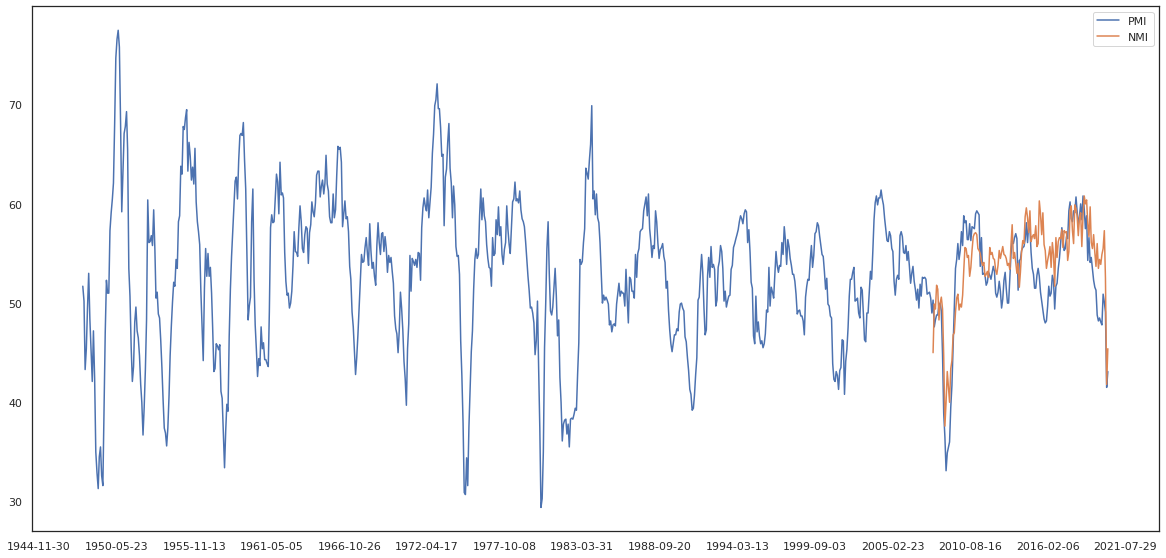

In [34]:
fig, ax = plt.subplots()
ax.plot(ism_pmi.index.values, ism_pmi['PMI'].values)
ax.plot(ism_nmi.index.values, ism_nmi['NMI'].values)
ax.xaxis.set_major_locator(ticker.MultipleLocator(2000))
ax.legend(['PMI', 'NMI'])
plt.show()


Non-manufacturing index (NMI) is available only post 2008. <br /> It cannot cover a lot percentage of the target period, decided not to use it.

### Retail Sales

In [35]:
filename = sales_data_dir + 'RRSFS.csv'
rrsfs = pd.read_csv(filename, header=0)
rrsfs = rrsfs.set_index(pd.to_datetime(rrsfs['DATE'], format="%Y-%m-%d")).drop(columns=['DATE'])
rrsfs['diff_prev'] = rrsfs['RRSFS'].diff() / rrsfs['RRSFS'].shift(1) * 100
rrsfs['diff_year'] = rrsfs['RRSFS'].diff(periods=12) / rrsfs['RRSFS'].shift(12) * 100
rrsfs

,RRSFS,diff_prev,diff_year
DATE,,,
1992-01-01,118651,NaN,NaN
1992-02-01,118480,-0.144120,NaN
1992-03-01,117700,-0.658339,NaN
1992-04-01,118156,0.387426,NaN
1992-05-01,118548,0.331765,NaN
...,...,...,...
2019-12-01,203319,-0.154199,3.245873
2020-01-01,204627,0.643324,2.326291
2020-02-01,203541,-0.530722,2.108479


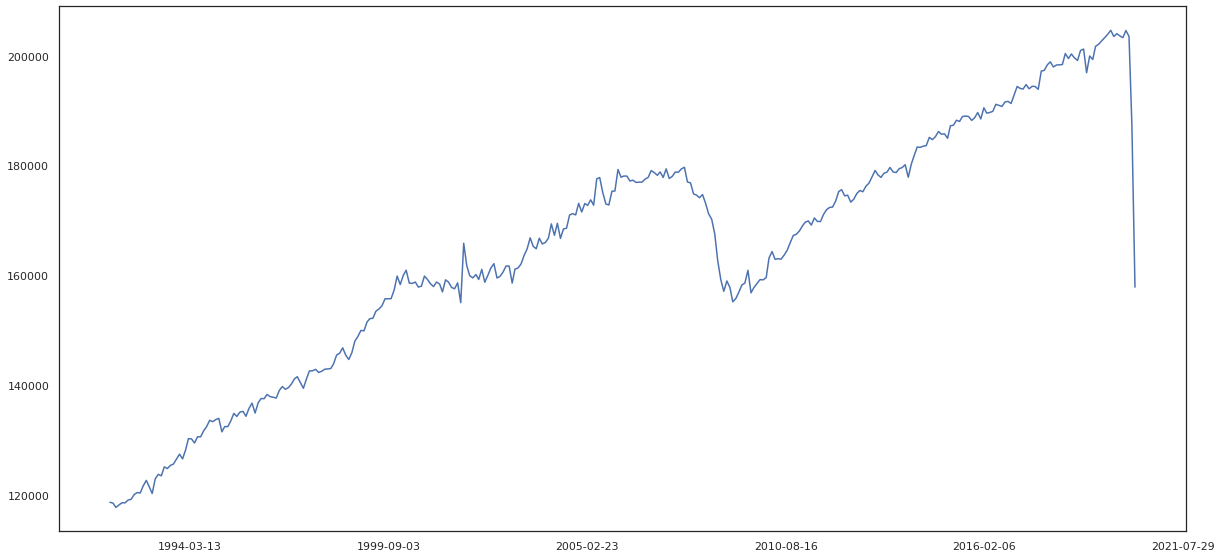

In [36]:
fig, ax = plt.subplots()
ax.plot(rrsfs.index.values, rrsfs['RRSFS'].values)
ax.xaxis.set_major_locator(ticker.MultipleLocator(2000))
plt.show()

### New Home Sales

In [37]:
filename = sales_data_dir + 'HSN1F.csv'
hsn1f = pd.read_csv(filename, header=0)
hsn1f = hsn1f.set_index(pd.to_datetime(hsn1f['DATE'], format="%Y-%m-%d")).drop(columns=['DATE'])
hsn1f['diff_prev'] = hsn1f['HSN1F'].diff() / hsn1f['HSN1F'].shift(1) * 100
hsn1f['diff_year'] = hsn1f['HSN1F'].diff(periods=12) / hsn1f['HSN1F'].shift(12) * 100
hsn1f

,HSN1F,diff_prev,diff_year
DATE,,,
1963-01-01,591.0,NaN,NaN
1963-02-01,464.0,-21.489002,NaN
1963-03-01,461.0,-0.646552,NaN
1963-04-01,605.0,31.236443,NaN
1963-05-01,586.0,-3.140496,NaN
...,...,...,...
2019-12-01,731.0,5.028736,29.609929
2020-01-01,774.0,5.882353,21.507064
2020-02-01,717.0,-7.364341,7.819549


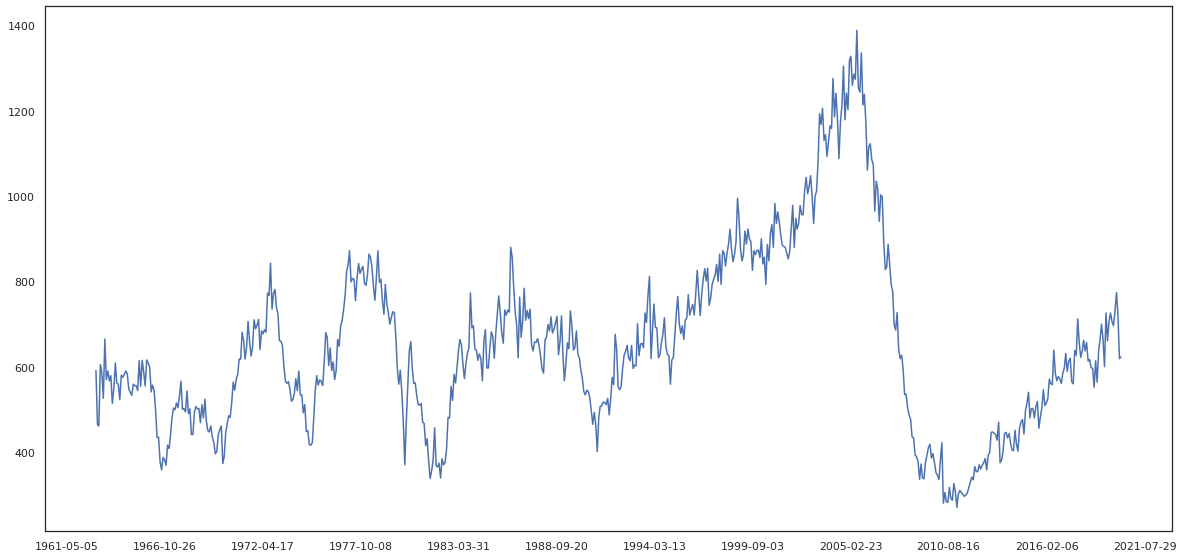

In [38]:
fig, ax = plt.subplots()
ax.plot(hsn1f.index.values, hsn1f['HSN1F'].values)
ax.xaxis.set_major_locator(ticker.MultipleLocator(2000))
plt.show()

### Treasury Yield

In [39]:
# https://www.treasury.gov/resource-center/data-chart-center/interest-rates/Pages/TextView.aspx?data=yieldAll

xml_path = treasury_data_dir + 'DailyTreasuryYieldCurveRateData.xml'
xml_data = etree.parse(xml_path)

namespaces = {"base": "http://data.treasury.gov/Feed.svc/",
              "d": "http://schemas.microsoft.com/ado/2007/08/dataservices",
              "m": "http://schemas.microsoft.com/ado/2007/08/dataservices/metadata",
              "x": "http://www.w3.org/2005/Atom"}

df_cols = ["date", "1mo", "2mo", "3mo", "6montn", "1yr", "2yr", "3yr", "5yr", "7yr", "10yr", "20yr", "30yr"]
rows = []

contents = xml_data.xpath('/x:feed/x:entry/x:content', namespaces=namespaces)
for content in contents:
    s_date = content.xpath('./m:properties/d:NEW_DATE', namespaces=namespaces)[0].text[:10]
    s_1mo = content.xpath('./m:properties/d:BC_1MONTH', namespaces=namespaces)[0].text
    s_2mo = content.xpath('./m:properties/d:BC_2MONTH', namespaces=namespaces)[0].text
    s_3mo = content.xpath('./m:properties/d:BC_3MONTH', namespaces=namespaces)[0].text
    s_6mo = content.xpath('./m:properties/d:BC_6MONTH', namespaces=namespaces)[0].text
    s_1yr = content.xpath('./m:properties/d:BC_1YEAR', namespaces=namespaces)[0].text
    s_2yr = content.xpath('./m:properties/d:BC_2YEAR', namespaces=namespaces)[0].text
    s_3yr = content.xpath('./m:properties/d:BC_3YEAR', namespaces=namespaces)[0].text
    s_5yr = content.xpath('./m:properties/d:BC_5YEAR', namespaces=namespaces)[0].text
    s_7yr = content.xpath('./m:properties/d:BC_7YEAR', namespaces=namespaces)[0].text
    s_10yr = content.xpath('./m:properties/d:BC_10YEAR', namespaces=namespaces)[0].text
    s_20yr = content.xpath('./m:properties/d:BC_20YEAR', namespaces=namespaces)[0].text
    s_30yr = content.xpath('./m:properties/d:BC_30YEAR', namespaces=namespaces)[0].text
    
    rows.append({"date": dt.datetime.strptime(s_date, '%Y-%m-%d'),
                 "1mo": s_1mo,
                 "2mo": s_2mo, 
                 "3montn": s_3mo, 
                 "6montn": s_6mo, 
                 "1yr": s_1yr, 
                 "2yr": s_2yr, 
                 "3yr": s_3yr, 
                 "5yr": s_5yr, 
                 "7yr": s_7yr, 
                 "10yr": s_10yr, 
                 "20yr": s_20yr, 
                 "30yr": s_30yr})

treasury = pd.DataFrame(rows, columns = df_cols).set_index('date').sort_index(ascending=True).astype(float)
treasury

,1mo,2mo,3mo,6montn,1yr,2yr,3yr,5yr,7yr,10yr,20yr,30yr
date,,,,,,,,,,,,
1990-01-02,NaN,NaN,NaN,7.89,7.81,7.87,7.90,7.87,7.98,7.94,NaN,8.00
1990-01-03,NaN,NaN,NaN,7.94,7.85,7.94,7.96,7.92,8.04,7.99,NaN,8.04
1990-01-04,NaN,NaN,NaN,7.90,7.82,7.92,7.93,7.91,8.02,7.98,NaN,8.04
1990-01-05,NaN,NaN,NaN,7.85,7.79,7.90,7.94,7.92,8.03,7.99,NaN,8.06
1990-01-08,NaN,NaN,NaN,7.88,7.81,7.90,7.95,7.92,8.05,8.02,NaN,8.09
...,...,...,...,...,...,...,...,...,...,...,...,...
2020-06-01,0.12,0.14,NaN,0.18,0.17,0.14,0.20,0.31,0.50,0.66,1.22,1.46
2020-06-02,0.12,0.13,NaN,0.18,0.17,0.17,0.20,0.32,0.52,0.68,1.24,1.48
2020-06-03,0.12,0.14,NaN,0.19,0.17,0.19,0.26,0.38,0.59,0.77,1.32,1.56


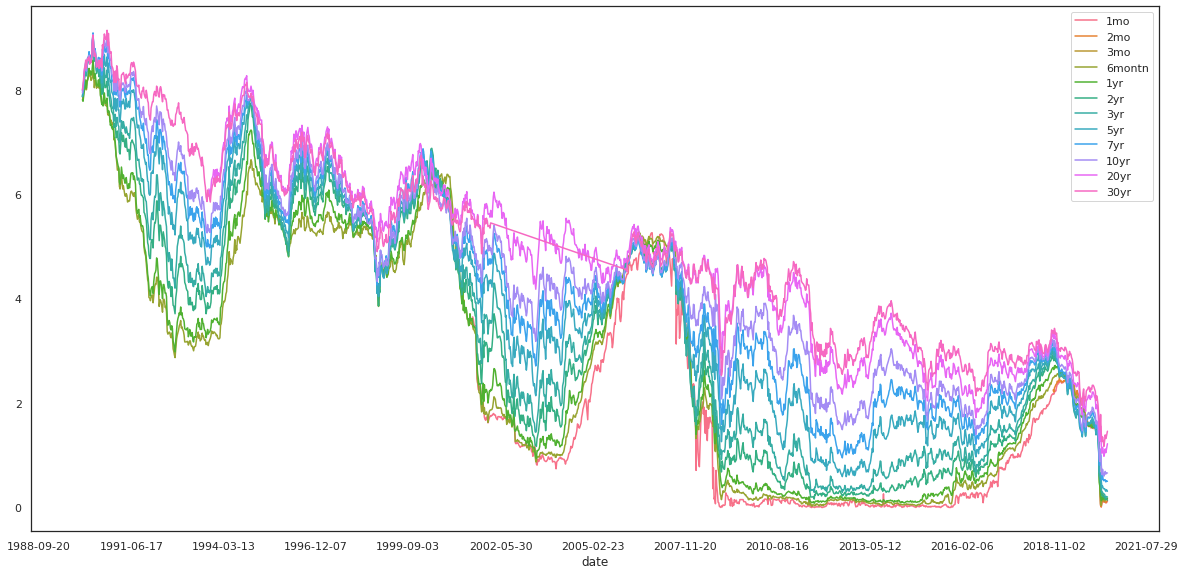

In [40]:
treasury_5 = treasury.iloc[::5, :]
fig, ax = plt.subplots()
ax = sns.lineplot(data = treasury_5, dashes=False)
ax.xaxis.set_major_locator(ticker.MultipleLocator(1000))
plt.show()

# Process the data

## Add Rate and Decisions

In [41]:
# -1: Rate lower
#  0: No change
# +1: Rate hike

rate_list = []
decision_list = []
rate_diff_list = []

for i in tqdm(range(len(fomc_calendar))):
    not_found = True
    for j in range(len(fedrate_df)):
        if fomc_calendar.index[i] == fedrate_df.index[j]:
            not_found = False
            rate_list.append(float(fedrate_df['Rate'].iloc[j+3]))
            rate_diff_list.append(float(fedrate_df['Rate'].iloc[j+3]) - float(fedrate_df['Rate'].iloc[j-1]))
            if fedrate_df['Rate'].iloc[j-1] == fedrate_df['Rate'].iloc[j+3]:
                decision_list.append(0)
            elif fedrate_df['Rate'].iloc[j-1] < fedrate_df['Rate'].iloc[j+3]:
                decision_list.append(1)
            elif fedrate_df['Rate'].iloc[j-1] > fedrate_df['Rate'].iloc[j+3]:
                decision_list.append(-1)
            break
    if not_found:
        rate_list.append(np.nan)
        decision_list.append(np.nan)
        rate_diff_list.append(np.nan)

fomc_calendar.loc[:,'Rate'] = rate_list
fomc_calendar.loc[:,'RateDiff'] = rate_diff_list
fomc_calendar.loc[:,'RateDecision'] = decision_list
fomc_calendar['RateDecision'] = fomc_calendar['RateDecision'].astype('Int8')

fomc_calendar

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

Se

,unscheduled,forecast,confcall,ChairPerson,Rate,RateDiff,RateDecision
date,,,,,,,
1982-10-05,False,False,False,Paul Volcker,9.5,-0.5,-1
1982-11-16,False,False,False,Paul Volcker,9.0,-0.5,-1
1982-12-21,False,False,False,Paul Volcker,8.5,0.0,0
1983-01-14,False,False,True,Paul Volcker,8.5,0.0,0
1983-01-21,False,False,True,Paul Volcker,8.5,0.0,0
...,...,...,...,...,...,...,...
2021-06-16,False,True,False,Jerome Powell,NaN,NaN,<NA>
2021-07-28,False,False,False,Jerome Powell,NaN,NaN,<NA>
2021-09-22,False,True,False,Jerome Powell,NaN,NaN,<NA>


In [42]:
fomc_calendar.loc[fomc_calendar['Rate'].isnull()]

,unscheduled,forecast,confcall,ChairPerson,Rate,RateDiff,RateDecision
date,,,,,,,
2020-06-10,False,True,False,Jerome Powell,NaN,NaN,<NA>
2020-07-29,False,False,False,Jerome Powell,NaN,NaN,<NA>
2020-08-27,False,False,False,Jerome Powell,NaN,NaN,<NA>
2020-09-16,False,True,False,Jerome Powell,NaN,NaN,<NA>
2020-11-05,False,False,False,Jerome Powell,NaN,NaN,<NA>
2020-12-16,False,True,False,Jerome Powell,NaN,NaN,<NA>
2021-01-27,False,False,False,Jerome Powell,NaN,NaN,<NA>
2021-03-17,False,True,False,Jerome Powell,NaN,NaN,<NA>
2021-04-28,False,False,False,Jerome Powell,NaN,NaN,<NA>


## Add Quantitative Easing as a Lower event

In [43]:
def parse_values(x):
  if x == 0:
    return 0
  elif x == 1:
    return 1
  elif x == -1:
    return 1
  else:
    return 0

In [44]:
rec_20081125 = pd.Series([True, False, False, 'Ben Bernanke', 0, -1, -1], index=['unscheduled', 'forecast', 'confcall', 'ChairPerson', 'Rate', 'RateDiff', 'RateDecision'], name=dt.datetime.strptime('2008-11-25', '%Y-%m-%d'))
if fomc_calendar.loc[fomc_calendar.index == dt.datetime.strptime('2008-11-25', '%Y-%m-%d')].shape[0] == 0:
    fomc_calendar = fomc_calendar.append(rec_20081125)

fomc_calendar.loc[fomc_calendar.index == dt.datetime(2009,3,18), ['RateDecision', 'RateDiff']] = (-1, -0.5) # QE1 Expanded
fomc_calendar.loc[fomc_calendar.index == dt.datetime(2010,11,3), ['RateDecision', 'RateDiff']] = (-1, -0.5) # QE2 Announced
fomc_calendar.loc[fomc_calendar.index == dt.datetime(2011,9,21), ['RateDecision', 'RateDiff']] = (-1, -0.5) # Operation Twist Announced
fomc_calendar.loc[fomc_calendar.index == dt.datetime(2012,6,20), ['RateDecision', 'RateDiff']] = (-1, -0.5) # Operation Twist Extended
fomc_calendar.loc[fomc_calendar.index == dt.datetime(2012,9,13), ['RateDecision', 'RateDiff']] = (-1, -0.5) # QE3 Announced
fomc_calendar.loc[fomc_calendar.index == dt.datetime(2012,12,12), ['RateDecision', 'RateDiff']] = (-1, -0.5) # QE3 Expanded
fomc_calendar.loc[fomc_calendar.index == dt.datetime(2013,6,19), ['RateDecision', 'RateDiff']] = (1, 1) # Tapering Announced
fomc_calendar.loc['2013-12-18', ['RateDecision', 'RateDiff']] = (1, 1) # Tapering Begins
fomc_calendar.loc['2014-10-29', ['RateDecision', 'RateDiff']] = (1, 0.5) # QE3 Terminated
fomc_calendar.loc['2017-06-14', ['RateDecision', 'RateDiff']] = (1, 0.5) # Signaled Balance Sheet Normalization
fomc_calendar.loc['2017-09-20', ['RateDecision', 'RateDiff']] = (1, 0.5) # Stated Balance Sheet Normalization Begins in October
fomc_calendar.sort_index(ascending=True, inplace=True)
fomc_calendar

,unscheduled,forecast,confcall,ChairPerson,Rate,RateDiff,RateDecision
date,,,,,,,
1982-10-05,False,False,False,Paul Volcker,9.5,-0.5,-1
1982-11-16,False,False,False,Paul Volcker,9.0,-0.5,-1
1982-12-21,False,False,False,Paul Volcker,8.5,0.0,0
1983-01-14,False,False,True,Paul Volcker,8.5,0.0,0
1983-01-21,False,False,True,Paul Volcker,8.5,0.0,0
...,...,...,...,...,...,...,...
2021-06-16,False,True,False,Jerome Powell,NaN,NaN,<NA>
2021-07-28,False,False,False,Jerome Powell,NaN,NaN,<NA>
2021-09-22,False,True,False,Jerome Powell,NaN,NaN,<NA>


In [45]:
fomc_calendar['RateDecision'] = fomc_calendar['RateDecision'].fillna(0)
fomc_calendar['RateChanged'] = fomc_calendar['RateDecision'].apply(lambda x: 0 if x == 0 else 1)

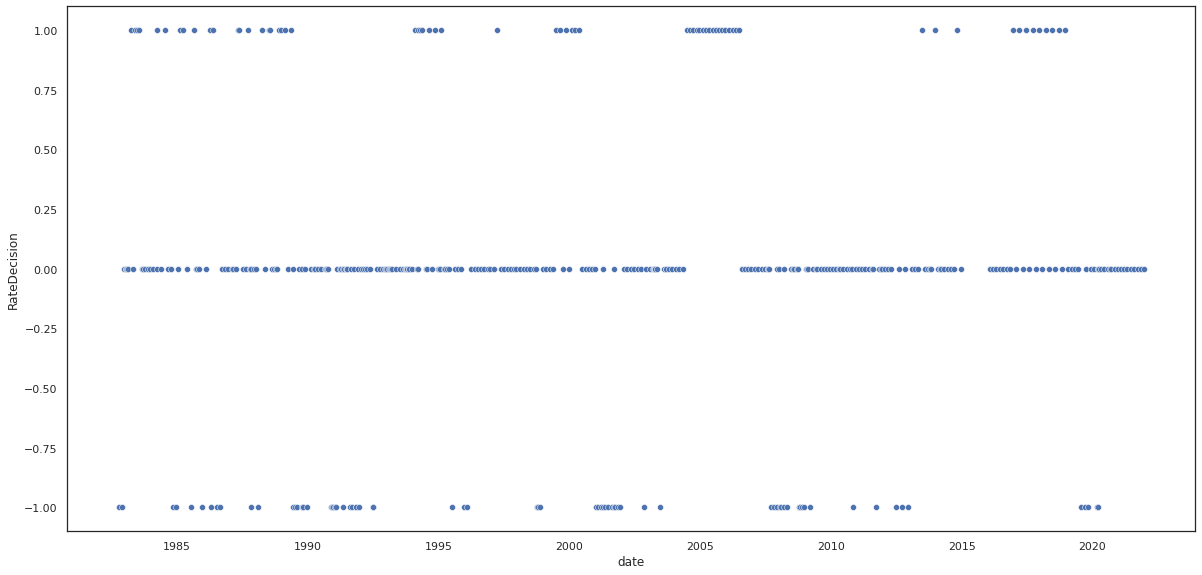

In [46]:
sns.scatterplot(x=fomc_calendar.index, y=fomc_calendar['RateDecision'].apply(lambda x: float(x)))

## Add major economic indices

In [47]:
def get_available_latest(train_df, index_df, value_col, diff_prev_col, diff_year_col, date_offset):
    '''
    Returns the latest available ecoonmic index for each row of train_df
    INPUTS:
        train_df: Index must be in datetime format
        idex_df: Index must be in datetime format
        value_col: The column name of the value in index_df
        diff_prev_col: The column name of the difference from previous period in index_df
        diff_year_col: The column name of the difference from the same priod in previous year in index_df
        date_offset: Use relativedelta for the offset when the index is published
    OUTPUTS:
        date_list: List of date matched with train_df.index
        value_list: List of values for the date_list
        diff_list: List of diff values for the date_list
    '''
    
    date_list, value_list, diff_prev_list, diff_year_list = [], [], [], []
    
    for i, row_data in tqdm(train_df.iterrows(), total=train_df.shape[0]):
        #print(row_data.name)
        not_available = True
        for j, row_index in index_df.sort_index(ascending=False).iterrows():
            if row_data.name > row_index.name + date_offset:
                #print("   matched: ", row_index.name)
                date_list.append(row_index.name)
                value_list.append(row_index[value_col])
                diff_prev_list.append(row_index[diff_prev_col])
                diff_year_list.append(row_index[diff_year_col])
                not_available = False
                break
        if not_available:
            date_list.append(None)
            value_list.append(None)
            diff_prev_list.append(None)
            diff_year_list.append(None)
    if train_df.shape[0] != len(date_list):
        print("train_df has {} rows but returned {} rows from index_df!".format(train_df.shape[0], len(date_list)))
    
    return date_list, value_list, diff_prev_list, diff_year_list

In [48]:
def add_market_data(calendar_df, window=1):
  df = calendar_df.copy(deep=True)
  df.dropna(subset=['Rate'], inplace=True)
  print("Processing GDP...")
  df['GDP_date'], df['GDP_value'], df['GDP_diff_prev'], df['GDP_diff_year'] \
  = get_available_latest(df, gdpc1.rolling(window).mean(), 'GDPC1', 'diff_prev', 'diff_year', relativedelta(months=+4, days=-2))
  print("Processing Potential GDP...")
  df['GDPPOT_date'], df['GDPPOT_value'], df['GDPPOT_diff_prev'], df['GDPPOT_diff_year'] \
  = get_available_latest(df, gdppot.rolling(window).mean(), 'GDPPOT', 'diff_prev', 'diff_year', relativedelta(months=+4, days=-2))
  print("Processing PCE...")
  df['PCE_date'], df['PCE_value'], df['PCE_diff_prev'], df['PCE_diff_year'] \
  = get_available_latest(df, pcepilfe.rolling(window).mean(), 'PCEPILFE', 'diff_prev', 'diff_year', relativedelta(months=+2, days=-1))
  print("Processing CPI...")
  df['CPI_date'], df['CPI_value'], df['CPI_diff_prev'], df['CPI_diff_year'] \
  = get_available_latest(df, cpiaucsl.rolling(window).mean(), 'CPIAUCSL', 'diff_prev', 'diff_year', relativedelta(months=+1, days=+9))
  print("Processing Unemployemnt...")
  df['Unemp_date'], df['Unemp_value'], df['Unemp_diff_prev'], df['Unemp_diff_year'] \
  = get_available_latest(df, unrate.rolling(window).mean(), 'UNRATE', 'diff_prev', 'diff_year', relativedelta(months=+1, days=+2))
  print("Processing Employment...")
  df['Employ_date'], df['Employ_value'], df['Employ_diff_prev'], df['Employ_diff_year'] \
  = get_available_latest(df, payems.rolling(window).mean(), 'PAYEMS', 'diff_prev', 'diff_year', relativedelta(months=+1, days=+2))
  print("Processing ISM PMI...")
  df['PMI_date'], df['PMI_value'], df['PMI_diff_prev'], df['PMI_diff_year'] \
  = get_available_latest(df, ism_pmi.rolling(window).mean(), 'PMI', 'diff_prev', 'diff_year', relativedelta(months=+1, days=+2))
  print("Processing ISM NMI...")
  df['NMI_date'], df['NMI_value'], df['NMI_diff_prev'], df['NMI_diff_year'] \
  = get_available_latest(df, ism_nmi.rolling(window).mean(), 'NMI', 'diff_prev', 'diff_year', relativedelta(months=+1, days=+2))
  print("Processing Retail Sales...")
  df['Rsales_date'], df['Rsales_value'], df['Rsales_diff_prev'], df['Rsales_diff_year'] \
  = get_available_latest(df, rrsfs.rolling(window).mean(), 'RRSFS', 'diff_prev', 'diff_year', relativedelta(months=+1, days=+2))
  print("Processing New Home Sales...")
  df['Hsales_date'], df['Hsales_value'], df['Hsales_diff_prev'], df['Hsales_diff_year'] \
  = get_available_latest(df, hsn1f.rolling(window).mean(), 'HSN1F', 'diff_prev', 'diff_year', relativedelta(months=+1, days=+2))
  return df

In [49]:
nontext_data = add_market_data(fomc_calendar)
nontext_data

Processing GDP...



Processing Potential GDP...



Processing PCE...



Processing CPI...



Processing Unemployemnt...



Processing Employment...



Processing ISM PMI...



Processing ISM NMI...



Processing Retail Sales...



Processing New Home Sales...


,unscheduled,forecast,confcall,ChairPerson,Rate,RateDiff,RateDecision,RateChanged,GDP_date,GDP_value,GDP_diff_prev,GDP_diff_year,GDPPOT_date,GDPPOT_value,GDPPOT_diff_prev,GDPPOT_diff_year,PCE_date,PCE_value,PCE_diff_prev,PCE_diff_year,CPI_date,CPI_value,CPI_diff_prev,CPI_diff_year,Unemp_date,Unemp_value,Unemp_diff_prev,Unemp_diff_year,Employ_date,Employ_value,Employ_diff_prev,Employ_diff_year,PMI_date,PMI_value,PMI_diff_prev,PMI_diff_year,NMI_date,NMI_value,NMI_diff_prev,NMI_diff_year,Rsales_date,Rsales_value,Rsales_diff_prev,Rsales_diff_year,Hsales_date,Hsales_value,Hsales_diff_prev,Hsales_diff_year
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1982-10-05,False,False,False,Paul Volcker,9.5,-0.5,-1,1,1982-04-01,6825.876,0.456197,-1.010549,1982-04-01,7224.140335,0.781241,2.925225,1982-08-01,47.798,0.460287,6.369058,1982-08-01,97.700,0.205128,5.965293,1982-09-01,-10.1,-0.3,-2.5,1982-09-01,89183.0,-180.0,-2294.0,1982-09-01,38.8,0.5,-3.7,NaT,NaN,NaN,NaN,NaT,NaN,NaN,NaN,1982-09-01,481.0,18.181818,42.307692
1982-11-16,False,False,False,Paul Volcker,9.0,-0.5,-1,1,1982-07-01,6799.781,-0.382295,-2.555898,1982-07-01,7282.431567,0.806895,3.080461,1982-09-01,47.975,0.370308,6.068981,1982-10-01,98.100,0.409417,5.032120,1982-10-01,-10.4,-0.3,-2.5,1982-10-01,88907.0,-276.0,-2473.0,1982-10-01,39.4,0.6,-0.6,NaT,NaN,NaN,NaN,NaT,NaN,NaN,NaN,1982-10-01,480.0,-0.207900,34.831461
1982-12-21,False,False,False,Paul Volcker,8.5,0.0,0,0,1982-07-01,6799.781,-0.382295,-2.555898,1982-07-01,7282.431567,0.806895,3.080461,1982-10-01,48.279,0.633663,6.110024,1982-11-01,98.000,-0.101937,4.477612,1982-11-01,-10.8,-0.4,-2.5,1982-11-01,88786.0,-121.0,-2385.0,1982-11-01,39.2,-0.2,3.1,NaT,NaN,NaN,NaN,NaT,NaN,NaN,NaN,1982-11-01,554.0,15.416667,45.026178
1983-01-14,False,False,True,Paul Volcker,8.5,0.0,0,0,1982-07-01,6799.781,-0.382295,-2.555898,1982-07-01,7282.431567,0.806895,3.080461,1982-11-01,48.458,0.370762,5.884409,1982-12-01,97.700,-0.306122,3.825717,1982-12-01,-10.8,0.0,-2.3,1982-12-01,88771.0,-15.0,-2124.0,1982-12-01,42.8,3.6,5.0,NaT,NaN,NaN,NaN,NaT,NaN,NaN,NaN,1982-12-01,521.0,-5.956679,14.004376
1983-01-21,False,False,True,Paul Volcker,8.5,0.0,0,0,1982-07-01,6799.781,-0.382295,-2.555898,1982-07-01,7282.431567,0.806895,3.080461,1982-11-01,48.458,0.370762,5.884409,1982-12-01,97.700,-0.306122,3.825717,1982-12-01,-10.8,0.0,-2.3,1982-12-01,88771.0,-15.0,-2124.0,1982-12-01,42.8,3.6,5.0,NaT,NaN,NaN,NaN,NaT,NaN,NaN,NaN,1982-12-01,521.0,-5.956679,14.004376
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-03-15,True,False,False,Jerome Powell,0.0,-1.0,-1,1,2019-10-01,19221.970,0.527469,2.334074,2019-10-01,19099.880000,0.521081,2.078186,2020-01-01,112.725,0.155486,1.689640,2020-02-01,259.050,0.088865,2.318104,2020-02-01,-3.5,0.1,0.3,2020-02-01,152463.0,251.0,2328.0,2020-02-01,50.1,-0.8,-4.0,2020-02-01,57.3,1.8,-2.4,2020-02-01,203541.0,-0.530722,2.108479,2020-02-01,717.0,-7.364341,7.819549
2020-03-19,False,False,False,Jerome Powell,0.0,0.0,0,0,2019-10-01,19221.970,0.527469,2.334074,2019-10-01,19099.880000,0.521081,2.078186,2020-01-01,112.725,0.155486,1.689640,2020-02-01,259.050,0.088865,2.318104,2020-02-01,-3.5,0.1,0.3,2020-02-01,152463.0,251.0,2328.0,2020-02-01,50.1,-0.8,-4.0,2020-02-01,57.3,1.8,-2.4,2020-02-01,203541.0,-0.530722,2.108479,2020-02-01,717.0,-7.364341,7.819549
2020-03-23,False,False,False,Jerome Powell,0.0,0.0,0,0,2019-10-01,19221.970,0.527469,2.334074,2019-10-01,19099.880000,0.521081,2.078186,2020-01-01,112.725,0.155486,1.689640,2020-02-01,259.050,0.088865,2.318104,2020-02-01,-3.5,0.1,0.3,2020-02-01,152463.0,251.0,2328.0,2020-02-01,50.1,-0.8,-4.0,2020-02-01,57.3,1.8,-2.4,2020-02-01,203541.0,-0.530722,2.108479,2020-02-01,717.0,-7.364341,7.819549


In [50]:
nontext_ma2 = add_market_data(fomc_calendar, 2)
nontext_ma3 = add_market_data(fomc_calendar, 3)
nontext_ma6 = add_market_data(fomc_calendar, 6)
nontext_ma12 = add_market_data(fomc_calendar, 12)

Processing GDP...



Processing Potential GDP...



Processing PCE...



Processing CPI...



Processing Unemployemnt...



Processing Employment...



Processing ISM PMI...



Processing ISM NMI...



Processing Retail Sales...



Processing New Home Sales...



Processing GDP...



Processing Potential GDP...



Processing PCE...



Processing CPI...



Processing Unemployemnt...



Processing Employment...



Processing ISM PMI...



Processing ISM NMI...



Processing Retail Sales...



Processing New Home Sales...



Processing GDP...



Processing Potential GDP...



Processing PCE...



Processing CPI...



Processing Unemployemnt...



Processing Employment...



Processing ISM PMI...



Processing ISM NMI...



Processing Retail Sales...



Processing New Home Sales...



Processing GDP...



Processing Potential GDP...



Processing PCE...



Processing CPI...



Processing Unemployemnt...



Processing Employment...



Processing ISM PMI...



Processing ISM NMI...



Processing Retail Sales...



Processing New Home Sales...


## Add Taylor Rule
https://www.federalreserve.gov/monetarypolicy/policy-rules-and-how-policymakers-use-them.htm

In [51]:
taylor = fedrate_df.copy(deep=True)
_, taylor['Y'],_,_ = get_available_latest(taylor, gdpc1, 'GDPC1', 'diff_prev', 'diff_year', relativedelta(months=+4, days=-2))
_, taylor['Yp'],_,_ = get_available_latest(taylor, gdppot, 'GDPPOT', 'diff_prev', 'diff_year', relativedelta(months=+4, days=-2))
taylor['Y-Yp'] = (np.log(taylor['Y']*10**9) - np.log(taylor['Yp']*10**9)) * 100
_, _,_, taylor['Pi'] = get_available_latest(taylor, pcepilfe, 'PCEPILFE', 'diff_prev', 'diff_year', relativedelta(months=+2, days=-1))
taylor['Pi*'] = 2
taylor['Pi-Pi*'] = taylor['Pi'] - taylor['Pi*']
taylor['r'] = 2


In [52]:
taylor['Taylor'] = taylor['r'] + taylor['Pi'] + 0.5 * taylor['Pi-Pi*'] + 0.5 * taylor['Y-Yp']
taylor['Balanced'] = (taylor['r'] + taylor['Pi'] + 0.5 * taylor['Pi-Pi*'] + taylor['Y-Yp']).map(lambda x: 0 if x < 0 else x)
taylor['Inertia'] = 0.85 * taylor['Rate'] - 0.15 * taylor['Balanced']
taylor = taylor.drop(columns = ['Y', 'Yp', 'Y-Yp', 'Pi', 'Pi*', 'Pi-Pi*', 'r', 'diff'])

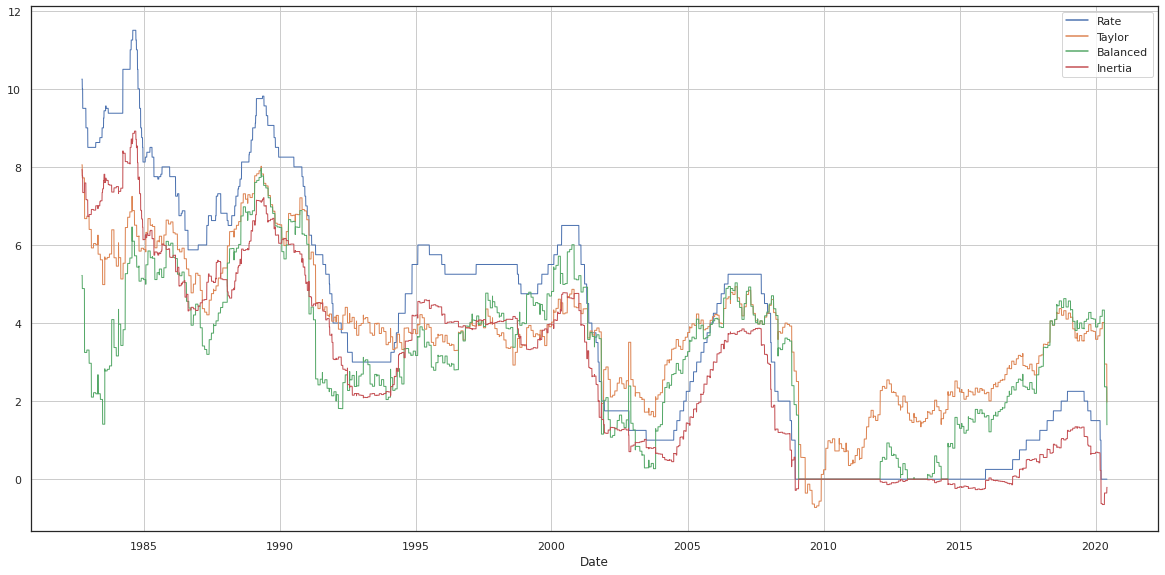

In [53]:
fig, ax = plt.subplots()
ax = sns.lineplot(data=taylor, dashes=False, lw=1)
plt.grid(True)
plt.show()

In [54]:
taylor['Taylor-Rate'] = taylor['Taylor'] - taylor['Rate']
taylor['Balanced-Rate'] = taylor['Balanced'] - taylor['Rate']
taylor['Inertia-Rate'] = taylor['Inertia'] - taylor['Rate']
taylor['Taylor_diff'] = taylor['Taylor'].diff(1)
taylor['Balanced_diff'] = taylor['Balanced'].diff(1)
taylor['Inertia_diff'] = taylor['Inertia'].diff(1)
taylor

,Rate,Taylor,Balanced,Inertia,Taylor-Rate,Balanced-Rate,Inertia-Rate,Taylor_diff,Balanced_diff,Inertia_diff
Date,,,,,,,,,,
1982-09-27,10.25,8.054621,5.219243,7.929613,-2.195379,-5.030757,-2.320387,NaN,NaN,NaN
1982-09-28,10.25,8.054621,5.219243,7.929613,-2.195379,-5.030757,-2.320387,0.000000,0.000000,0.000000
1982-09-29,10.25,8.054621,5.219243,7.929613,-2.195379,-5.030757,-2.320387,0.000000,0.000000,0.000000
1982-09-30,10.25,8.054621,5.219243,7.929613,-2.195379,-5.030757,-2.320387,0.000000,0.000000,0.000000
1982-10-01,10.00,7.718209,4.882832,7.767575,-2.281791,-5.117168,-2.232425,-0.336412,-0.336412,-0.162038
...,...,...,...,...,...,...,...,...,...,...
2020-05-30,0.00,2.949439,2.365532,-0.354830,2.949439,2.365532,-0.354830,0.000000,0.000000,0.000000
2020-05-31,0.00,2.949439,2.365532,-0.354830,2.949439,2.365532,-0.354830,0.000000,0.000000,0.000000
2020-06-01,0.00,1.977694,1.393788,-0.209068,1.977694,1.393788,-0.209068,-0.971744,-0.971744,0.145762


In [55]:
def add_taylor(df, window=1):
    taylor_ma = taylor.rolling(window).mean()
    df['Taylor'] = df.index.map(lambda x: taylor_ma.loc[taylor_ma.index == x + relativedelta(days=-1), 'Taylor'].values[0])
    df['Balanced'] = df.index.map(lambda x: taylor_ma.loc[taylor_ma.index == x + relativedelta(days=-1), 'Balanced'].values[0])
    df['Inertia'] = df.index.map(lambda x: taylor_ma.loc[taylor_ma.index == x + relativedelta(days=-1), 'Inertia'].values[0])
    df['Taylor-Rate'] = df.index.map(lambda x: taylor_ma.loc[taylor_ma.index == x + relativedelta(days=-1), 'Taylor-Rate'].values[0])
    df['Balanced-Rate'] = df.index.map(lambda x: taylor_ma.loc[taylor_ma.index == x + relativedelta(days=-1), 'Balanced-Rate'].values[0])
    df['Inertia-Rate'] = df.index.map(lambda x: taylor_ma.loc[taylor_ma.index == x + relativedelta(days=-1), 'Inertia-Rate'].values[0])
    df['Taylor_diff'] = df['Taylor'].diff(1)
    df['Balanced_diff'] = df['Balanced'].diff(1)
    df['Inertia_diff'] = df['Inertia'].diff(1)

In [56]:
add_taylor(nontext_data)
add_taylor(nontext_ma2, 60)
add_taylor(nontext_ma3, 90)
add_taylor(nontext_ma6, 180)
add_taylor(nontext_ma12, 360)

In [57]:
fomc_calendar.index.get_level_values(0).values

array(['1982-10-05T00:00:00.000000000', '1982-11-16T00:00:00.000000000',
       '1982-12-21T00:00:00.000000000', '1983-01-14T00:00:00.000000000',
       '1983-01-21T00:00:00.000000000', '1983-01-28T00:00:00.000000000',
       '1983-02-09T00:00:00.000000000', '1983-03-29T00:00:00.000000000',
       '1983-04-29T00:00:00.000000000', '1983-05-24T00:00:00.000000000',
       '1983-06-23T00:00:00.000000000', '1983-07-13T00:00:00.000000000',
       '1983-08-23T00:00:00.000000000', '1983-09-08T00:00:00.000000000',
       '1983-10-04T00:00:00.000000000', '1983-11-15T00:00:00.000000000',
       '1983-12-20T00:00:00.000000000', '1984-01-31T00:00:00.000000000',
       '1984-03-20T00:00:00.000000000', '1984-03-27T00:00:00.000000000',
       '1984-05-22T00:00:00.000000000', '1984-07-17T00:00:00.000000000',
       '1984-08-21T00:00:00.000000000', '1984-10-02T00:00:00.000000000',
       '1984-11-07T00:00:00.000000000', '1984-12-18T00:00:00.000000000',
       '1985-01-18T00:00:00.000000000', '1985-02-13

In [58]:
fomc_calendar.loc['2020-06-10', 'Rate'] = 0
fomc_calendar.loc['2020-07-29', 'Rate'] = 0
fomc_calendar.loc['2020-06-10', 'RateDiff'] = 0
fomc_calendar.loc['2020-07-29', 'RateDiff'] = 0

## Save the train data

In [59]:
if IN_COLAB:
  def save_data(df, file_name, dir_name=preprocessed_dir):
    if not os.path.exists(dir_name):
      os.mkdir(dir_name)
    # Save results to a picke file
    file = open(dir_name + file_name + '.pickle', 'wb')
    pickle.dump(df, file)
    file.close()
    # Save results to a csv file
    df.to_csv(dir_name + file_name + '.csv', index=True)
else:
  def save_data(df, file_name, dir_name=preprocessed_dir):
    # Save results to a .picke file
    file = open(dir_name + file_name + '.pickle', 'wb')
    pickle.dump(df, file)
    file.close()
    # Save results to a .csv file
    df.to_csv(dir_name + file_name + '.csv', index=True)

In [60]:
# Save data
save_data(nontext_data, 'nontext_data')
save_data(nontext_ma2, 'nontext_ma2')
save_data(nontext_ma3, 'nontext_ma3')
save_data(nontext_ma6, 'nontext_ma6')
save_data(nontext_ma12, 'nontext_ma12')
save_data(treasury, 'treasury')
save_data(fomc_calendar, 'fomc_calendar')